## Section 7 - Consumption Savings with Uncertainty
ECON 210 - Fall 2025 -
Piazzesi & Schneider -
TA Manu Magalhães

We will study a household with log utility. From section slides, recursive problem is
$$
	\max_{b} u(b + y - c - b'/R) + \beta \sum_{y \in y_H,y_L} P(y'|y) V(y',b') \\
$$
 FOC:
$$
			u'(b + y_i - c - b'/R)/R = \beta\left[ P(y_L|y_i) \frac{\partial V(y_L,b')}{\partial b'}+P(y_H|y_i)\frac{\partial V(y_H,b')}{\partial'}\right]
$$

#### 0) Setting up the grid
Now, our grid is two dimensional: we have both the income level and bonds.

In [42]:
beta = 0.96
R = 1/beta
min_b = 0.2
max_b = 5
y_h = 4
y_l = 2
pi_hh = 0.9
pi_ll = 0.6
steps_b = 100
n_states_y = 2
import numpy as np
b_grid = np.linspace(min_b,max_b,steps_b)
y_grid = [[y_h],[y_l]]
Pi = np.array([[pi_hh, 1-pi_hh],
      [1-pi_ll,pi_ll]])


b_mesh, y_mesh = np.meshgrid(b_grid, y_grid)
# B_mesh and Y_mesh are 2D arrays where each combination is at position [i,j]
print(b_mesh)
print(y_mesh)

[[0.2        0.24848485 0.2969697  0.34545455 0.39393939 0.44242424
  0.49090909 0.53939394 0.58787879 0.63636364 0.68484848 0.73333333
  0.78181818 0.83030303 0.87878788 0.92727273 0.97575758 1.02424242
  1.07272727 1.12121212 1.16969697 1.21818182 1.26666667 1.31515152
  1.36363636 1.41212121 1.46060606 1.50909091 1.55757576 1.60606061
  1.65454545 1.7030303  1.75151515 1.8        1.84848485 1.8969697
  1.94545455 1.99393939 2.04242424 2.09090909 2.13939394 2.18787879
  2.23636364 2.28484848 2.33333333 2.38181818 2.43030303 2.47878788
  2.52727273 2.57575758 2.62424242 2.67272727 2.72121212 2.76969697
  2.81818182 2.86666667 2.91515152 2.96363636 3.01212121 3.06060606
  3.10909091 3.15757576 3.20606061 3.25454545 3.3030303  3.35151515
  3.4        3.44848485 3.4969697  3.54545455 3.59393939 3.64242424
  3.69090909 3.73939394 3.78787879 3.83636364 3.88484848 3.93333333
  3.98181818 4.03030303 4.07878788 4.12727273 4.17575758 4.22424242
  4.27272727 4.32121212 4.36969697 4.41818182 4.4

### 1) Solving with Value Function Iteration

In [43]:
# Start with guess
V_guess = np.log(b_mesh + y_mesh)
print(V_guess)

[[1.43508453 1.44656241 1.45791005 1.46913037 1.48022618 1.49120023
  1.50205515 1.51279351 1.52341778 1.53393036 1.54433357 1.55462968
  1.56482085 1.5749092  1.5848968  1.59478564 1.60457764 1.61427468
  1.6238786  1.63339115 1.64281407 1.65214903 1.66139765 1.67056152
  1.67964217 1.68864111 1.69755978 1.70639962 1.715162   1.72384826
  1.73245973 1.74099767 1.74946332 1.75785792 1.76618263 1.77443861
  1.78262699 1.79074886 1.7988053  1.80679735 1.81472603 1.82259234
  1.83039726 1.83814173 1.84582669 1.85345304 1.86102166 1.86853344
  1.8759892  1.88338979 1.89073601 1.89802866 1.90526851 1.91245633
  1.91959284 1.92667879 1.93371488 1.9407018  1.94764025 1.95453089
  1.96137437 1.96817134 1.97492242 1.98162823 1.98828937 1.99490644
  2.00148    2.00801064 2.0144989  2.02094533 2.02735048 2.03371486
  2.04003899 2.04632338 2.05256852 2.0587749  2.064943   2.07107329
  2.07716623 2.08322226 2.08924185 2.09522541 2.10117338 2.10708619
  2.11296423 2.11880793 2.12461768 2.13039387 2.

#### 1a) Coding up the first iteration

In [44]:
V_pre = V_guess

In [45]:
V_post = np.zeros(((n_states_y,steps_b)))
for b_index in range(steps_b):
    for y_index in range(n_states_y):
        T = np.full_like(b_grid,fill_value=-10^10)
        c_values = b_mesh[y_index,b_index] + y_mesh[y_index,b_index] - b_grid/R
        feasible = c_values > 0 
        T[feasible] = np.log(c_values[feasible]) + beta*(Pi[y_index,0]*V_pre[0,feasible]+Pi[y_index,1]*V_pre[1,feasible])
        V_post[y_index,b_index] = np.max(T)

# Check for convergence
print(sum(sum((V_pre - V_post)**2)))
V_pre = V_post.copy()

288.65557974981834


#### 1b) Full algorithm

In [46]:
error = 10
tol = 1e-4
max_iter = 3000
it = 0
import time
t_0 = time.time()
while ((error > tol) & (it < max_iter)):
    for b_index in range(steps_b):
        for y_index in range(n_states_y):
            T = np.full_like(b_grid,fill_value=-1e10)
            c_values = b_mesh[y_index,b_index] + y_mesh[y_index,b_index] - b_grid/R
            feasible = c_values > 0 
            T[feasible] = np.log(c_values[feasible]) + beta*(Pi[y_index,0]*V_pre[0,feasible]+Pi[y_index,1]*V_pre[1,feasible])
            V_post[y_index,b_index] = np.max(T)
    error = sum(sum((V_pre - V_post)**2))
    it +=1
    V_pre = V_post.copy()
t_1 = time.time()
t_VFI = t_1 - t_0
iters_VFI = it
print('Time for VFI:', t_VFI)
print(iters_VFI)

Time for VFI: 0.5830767154693604
183


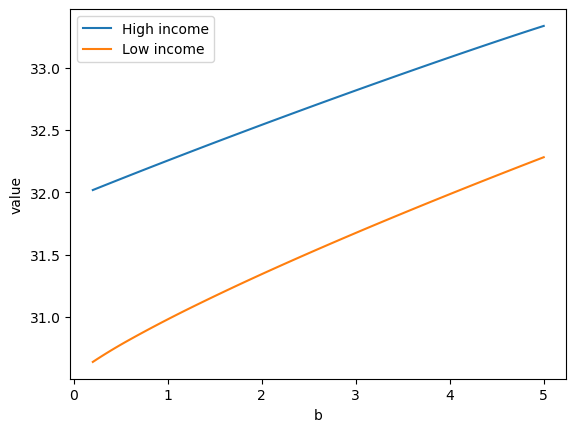

In [47]:
# Plotting value functions
import matplotlib.pyplot as plt

plt.plot(b_grid, V_post[0,:], label = 'High income')
plt.plot(b_grid, V_post[1,:], label = 'Low income')
plt.legend()
plt.xlabel('b')
plt.ylabel('value')
plt.show()

V_VFI = V_post.copy()

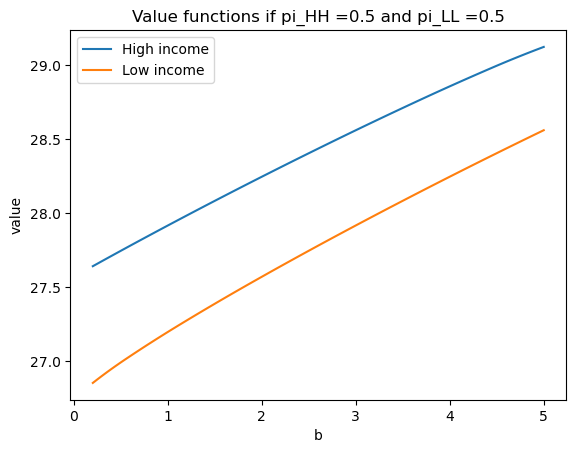

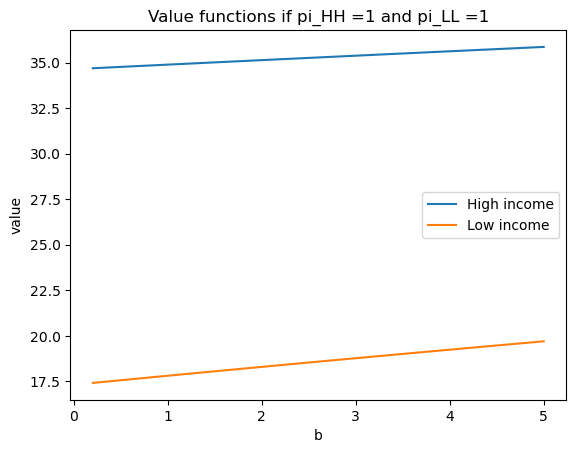

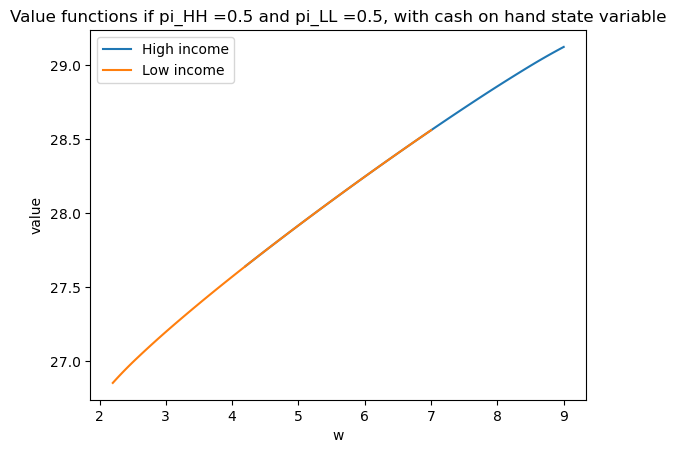

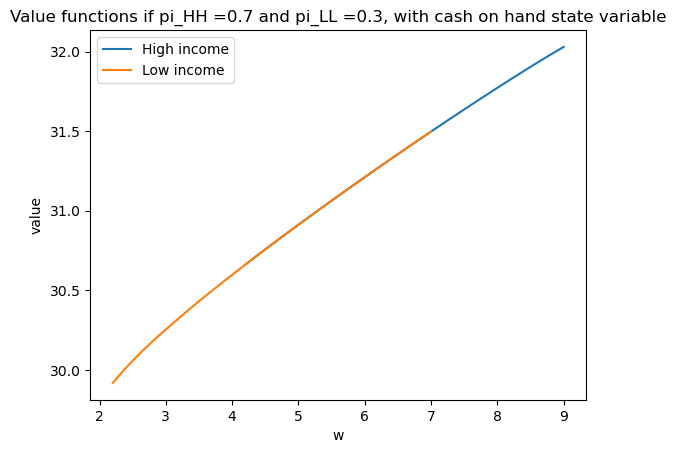

In [63]:
def solve_and_plot(pi_hh,pi_ll, cash_on_hand =False, steps_b = steps_b, beta = beta, min_b = min_b, max_b = max_b, y_h = y_h, y_l =y_l, n_states_y=n_states_y):
    import numpy as np
    b_grid = np.linspace(min_b,max_b,steps_b)
    y_grid = [[y_h],[y_l]]
    Pi = np.array([[pi_hh, 1-pi_hh],
        [1-pi_ll,pi_ll]])


    b_mesh, y_mesh = np.meshgrid(b_grid, y_grid)
    V_pre = np.log(b_mesh + y_mesh)
    error = 10
    tol = 1e-4
    max_iter = 3000
    it = 0

    while ((error > tol) & (it < max_iter)):
        for b_index in range(steps_b):
            for y_index in range(n_states_y):
                T = np.full_like(b_grid,fill_value=-1e10)
                c_values = b_mesh[y_index,b_index] + y_mesh[y_index,b_index] - b_grid/R
                feasible = c_values > 0 
                T[feasible] = np.log(c_values[feasible]) + beta*(Pi[y_index,0]*V_pre[0,feasible]+Pi[y_index,1]*V_pre[1,feasible])
                V_post[y_index,b_index] = np.max(T)
        error = sum(sum((V_pre - V_post)**2))
        it +=1
        V_pre = V_post.copy()
    if cash_on_hand == False:
        plt.plot(b_grid, V_post[0,:], label = 'High income')
        plt.plot(b_grid, V_post[1,:], label = 'Low income')
        plt.title(f'Value functions if pi_HH ={pi_hh} and pi_LL ={pi_ll}')
        plt.xlabel('b')

    else:
        plt.plot(b_grid+y_h, V_post[0,:], label = 'High income')
        plt.plot(b_grid+y_l, V_post[1,:], label = 'Low income')
        plt.title(f'Value functions if pi_HH ={pi_hh} and pi_LL ={pi_ll}, with cash on hand state variable')
        plt.xlabel('w')
    plt.legend()
    plt.ylabel('value')
    plt.show()


solve_and_plot(0.5,0.5)
solve_and_plot(1,1)

solve_and_plot(0.5,0.5, cash_on_hand=True)
solve_and_plot(0.7,0.3, cash_on_hand=True)


### 2) Howard's policy improvement algorithm

Instead of iterating in the value function, we iterate on the policy function.

#### 2a) Start with a guess
Let's start with a guess similar to the one we had for the value function: consume everything in each period.

In [49]:
b_prime_guess =  np.zeros((n_states_y, steps_b))  # no savings
b_prime_policy = b_prime_guess


### 2b) Compute the matrices

We want to compute the matrices from section slides so that we can solve for $V$.
We start by creating the P matrix. Since it has a lot of zeros, it is what we call a sparse matrix. When coding, sparse matrices are useful because they make computation much faster.

In [50]:
n_total_states = n_states_y*steps_b
u_vector = np.ones(n_total_states)*-1e10

# Build transition matrix P
row_indices = []
col_indices = []
values = []

for y_index in range(n_states_y):
    for b_index in range(steps_b):
        state_index = y_index * steps_b + b_index

        # states and policies
        b_current = b_mesh[y_index, b_index]
        y_current = y_mesh[y_index, b_index]
        b_prime_choice = b_prime_policy[y_index,b_index]
        c = b_current + y_current - b_prime_choice/R
        if c > 0:
            u_vector[state_index] = np.log(c)

        # index for bprime
        b_prime_index = np.argmin(np.abs(b_grid-b_prime_choice))

        # getting transition probabilities
        for y_next_index in range(n_states_y):
            prob = Pi[y_index,y_next_index]
            next_state_index = y_next_index * steps_b + b_prime_index

            # add to transition matrix
            row_indices.append(state_index)
            col_indices.append(next_state_index)
            values.append(prob)

# Create P - we create a sparse matrix
import scipy.sparse as sp
P_matrix = sp.csr_matrix((values,(row_indices,col_indices)),
                         shape=(n_total_states,n_total_states))

I_matrix = sp.eye(n_total_states,format='csr')
A_matrix = I_matrix - beta * P_matrix

### 2c) Solve for V

To solve for a linear system given by
$$ Ax = b $$
we can use spsolve(A,b) to get x.

In [51]:
from scipy.sparse.linalg import spsolve
V_vec = spsolve(A_matrix,u_vector)
V = V_vec.reshape((n_states_y, steps_b)) # bring it back to the shape we were using

### 2d) Get new policy

In [52]:
b_prime_policy_old = b_prime_policy.copy()
for b_index in range(steps_b):
    for y_index in range(n_states_y):
        T = np.full_like(b_grid, fill_value=-1e10)
        c_values = b_mesh[y_index,b_index] + y_mesh[y_index,b_index] - b_grid/R
        feasible = c_values > 0
        T[feasible] = np.log(c_values[feasible]) + beta * (
            Pi[y_index, 0] * V[0, feasible] + 
            Pi[y_index, 1] * V[1, feasible]
        )
        max_index = np.argmax(T)
        b_prime_policy[y_index,b_index] = b_grid[max_index]

### 2e) Check convergence
We want to compare the old policy with the new policy until they are sufficiently similar.

In [53]:
error = sum(sum((b_prime_policy_old - b_prime_policy)**2))
print(error)

424.35731864095504


### 2d) Iterate

For that, it is useful to first create a function that gets us V.

In [54]:
def get_V(b_prime_policy, b_mesh = b_mesh, y_mesh = y_mesh,n_states_y =n_states_y,steps_b = steps_b):
    u_vector = np.ones(n_total_states)*-1e10

    # Build transition matrix P
    row_indices = []
    col_indices = []
    values = []

    for y_index in range(n_states_y):
        for b_index in range(steps_b):
            state_index = y_index * steps_b + b_index

            # states and policies
            b_current = b_mesh[y_index, b_index]
            y_current = y_mesh[y_index, b_index]
            b_prime_choice = b_prime_policy[y_index,b_index]
            c = b_current + y_current - b_prime_choice/R
            if c > 0:
                u_vector[state_index] = np.log(c)

            # index for bprime
            b_prime_index = np.argmin(np.abs(b_grid-b_prime_choice))

            # getting transition probabilities
            for y_next_index in range(n_states_y):
                prob = Pi[y_index,y_next_index]
                next_state_index = y_next_index * steps_b + b_prime_index

                # add to transition matrix
                row_indices.append(state_index)
                col_indices.append(next_state_index)
                values.append(prob)

        # Create P - we create a sparse matrix
        import scipy.sparse as sp
        P_matrix = sp.csr_matrix((values,(row_indices,col_indices)),
                                shape=(n_total_states,n_total_states))

        I_matrix = sp.eye(n_total_states,format='csr')
        A_matrix = I_matrix - beta * P_matrix
        V_vec = spsolve(A_matrix,u_vector)
        V = V_vec.reshape((n_states_y, steps_b)) 
    return V

In [55]:
t0 = time.time()
it = 0
while ((error > tol) & (it < max_iter)):
    b_prime_policy_old = b_prime_policy.copy()
    V = get_V(b_prime_policy)
    for b_index in range(steps_b):
        for y_index in range(n_states_y):
            T = np.full_like(b_grid, fill_value=-1e10)
            c_values = b_mesh[y_index,b_index] + y_mesh[y_index,b_index] - b_grid/R
            feasible = c_values > 0
            T[feasible] = np.log(c_values[feasible]) + beta * (
                Pi[y_index, 0] * V[0, feasible] + 
                Pi[y_index, 1] * V[1, feasible]
            )
            max_index = np.argmax(T)
            b_prime_policy[y_index,b_index] = b_grid[max_index]
    error = sum(sum((b_prime_policy_old - b_prime_policy)**2))

    it +=1

print(it)
t1 = time.time()

11


### Comparing number of iterations and time to run across the two approaches

In [56]:
print(f'Time to run VFI was {t_VFI} and time to run policy iteration was {t1-t0}')
print(f'Howard\'s converged in iteration {it} and VFI in iteration {iters_VFI}' )

Time to run VFI was 0.5830767154693604 and time to run policy iteration was 0.052403926849365234
Howard's converged in iteration 11 and VFI in iteration 183


In [57]:
np.max(np.abs(V - V_VFI))

0.01675624249572394

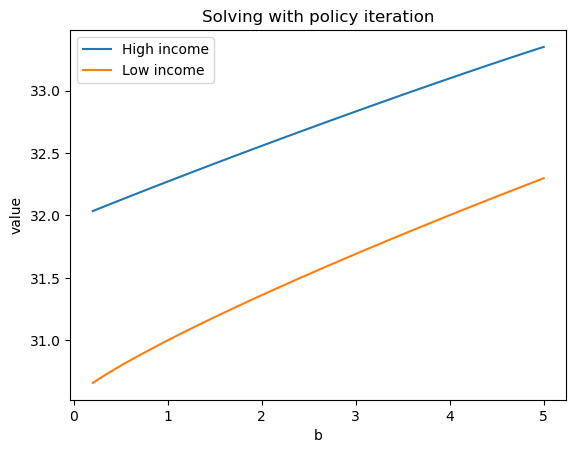

In [58]:
# Plotting value functions
import matplotlib.pyplot as plt

plt.plot(b_grid, V[0,:], label = 'High income')
plt.plot(b_grid, V[1,:], label = 'Low income')
plt.legend()
plt.title('Solving with policy iteration')
plt.xlabel('b')
plt.ylabel('value')
plt.show()

### If we have time: try policy iteration getting V through iterating

In [59]:
def get_V_iterating(b_prime_policy, b_mesh=b_mesh, y_mesh=y_mesh, n_states_y=n_states_y, steps_b=steps_b, b_grid=b_grid, Pi=Pi, beta=beta, R=R):
    V_pre = np.log(b_mesh + y_mesh) # initial guess
    error = 10
    tol_eval = 1e-6
    max_iter_eval = 1000
    it_eval = 0
    
    while ((error > tol_eval) & (it_eval < max_iter_eval)):
        V_post = np.zeros((n_states_y, steps_b))
        for b_index in range(steps_b):
            for y_index in range(n_states_y):
                b_current = b_mesh[y_index, b_index]
                y_current = y_mesh[y_index, b_index]
                b_prime_choice = b_prime_policy[y_index, b_index]
                c = b_current + y_current - b_prime_choice/R
                
                b_prime_index = np.argmin(np.abs(b_grid - b_prime_choice))
                
                if c > 0:
                    V_post[y_index, b_index] = np.log(c) + beta * (
                        Pi[y_index, 0] * V_pre[0, b_prime_index] + 
                        Pi[y_index, 1] * V_pre[1, b_prime_index]
                    )
                else:
                    V_post[y_index, b_index] = -1e10
        
        error = np.sum((V_pre - V_post)**2)
        it_eval += 1
        V_pre = V_post.copy()
    
    return V_post

In [60]:
b_prime_policy = np.zeros((n_states_y, steps_b))
t0A = time.time()
itA = 0
error = 10
while ((error > tol) & (itA < max_iter)):
    b_prime_policy_old = b_prime_policy.copy()
    V = get_V_iterating(b_prime_policy)
    for b_index in range(steps_b):
        for y_index in range(n_states_y):
            T = np.full_like(b_grid, fill_value=-1e10)
            c_values = b_mesh[y_index,b_index] + y_mesh[y_index,b_index] - b_grid/R
            feasible = c_values > 0
            T[feasible] = np.log(c_values[feasible]) + beta * (
                Pi[y_index, 0] * V[0, feasible] + 
                Pi[y_index, 1] * V[1, feasible]
            )
            max_index = np.argmax(T)
            b_prime_policy[y_index,b_index] = b_grid[max_index]
    error = sum(sum((b_prime_policy_old - b_prime_policy)**2))

    itA +=1

print(itA)
t1A = time.time()

12


In [61]:
print(f'Time to run policy with linear system was {t1-t0} and time to run with iterating was {t1A-t0A}')
print(f'Howard\'s with linear system converged in iteration {it} and VFI in iteration {itA}' )

Time to run policy with linear system was 0.052403926849365234 and time to run with iterating was 2.4617691040039062
Howard's with linear system converged in iteration 11 and VFI in iteration 12
